In [21]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
import time
from shapely.geometry import Point
import geodatasets

In [ ]:
cars = pd.read_csv("data/Used_Car_Price_Prediction.csv")
cars.head(10)

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False
5,maruti alto k10,2018,petrol,23534,335299,noida,1055,hatchback,NaN,vxi (o) amt,...,1,343212,439056.0,great,2021-04-13T05:55:16.99,True,7788,50295,False,False
6,maruti ritz,2012,diesel,41213,281999,noida,909,hatchback,manual,vdi,...,1,201200,NaN,great,2020-12-29T07:26:25.321,True,6550,42300,False,False
7,hyundai i20,2012,petrol,38328,321499,noida,2760,hatchback,manual,asta 1.2,...,3,319200,410764.0,great,2021-02-25T15:47:30.3,True,7468,48225,False,False
8,hyundai elite i20,2014,diesel,56402,456199,noida,2475,hatchback,manual,magna 1.4 crdi,...,1,452023,566123.0,great,2021-03-13T11:57:25.71,True,10596,68430,False,False
9,renault kwid,2018,petrol,32703,281299,noida,2497,hatchback,manual,rxl,...,1,264597,344127.0,great,2021-03-20T06:52:56.488,True,6534,42195,False,False


# Missing-Value Imputation

In [3]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
cars['original_price'] = imputer.fit_transform(cars[['original_price']])

# Visualizations

**Sale Price Vs Fuel Type, Transmission, and Body Type**  

This plot should show how sale_price behaves for different fuel types, transmissions, or body types.
Boxplots summerize the spread and skew of prices and compare groups side by side.

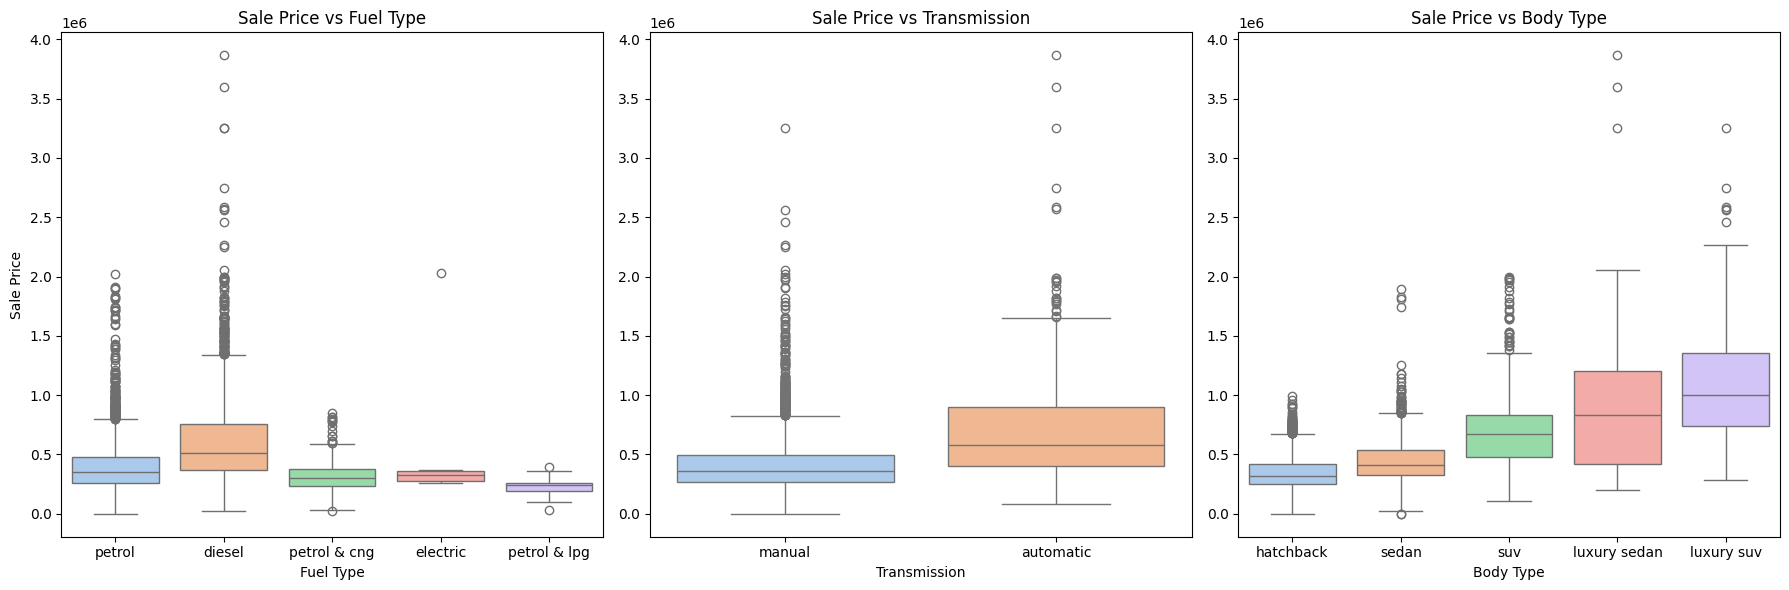

In [4]:
# Set up the figure with subplots for each categorical variable
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot: sale_price vs fuel_type
sns.boxplot(x='fuel_type', y='sale_price', data=cars, ax=axes[0],
            hue='fuel_type', palette='pastel', legend=False)
axes[0].set_title('Sale Price vs Fuel Type', fontsize=12)
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('Sale Price')

# Boxplot: sale_price vs transmission
sns.boxplot(x='transmission', y='sale_price', data=cars, ax=axes[1],
           hue='transmission', palette='pastel', legend=False)
axes[1].set_title('Sale Price vs Transmission', fontsize=12)
axes[1].set_xlabel('Transmission')
axes[1].set_ylabel('')

# Boxplot: sale_price vs body_type
sns.boxplot(x='body_type', y='sale_price', data=cars, ax=axes[2],
           hue='body_type', palette='pastel', legend=False)
axes[2].set_title('Sale Price vs Body Type', fontsize=12)
axes[2].set_xlabel('Body Type')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

**Sale Price Vs Year of Manufacture depending on Fuel Type**

Scatter plot with Trendline : Reveals depreciation rate and whether fuel types age differently.


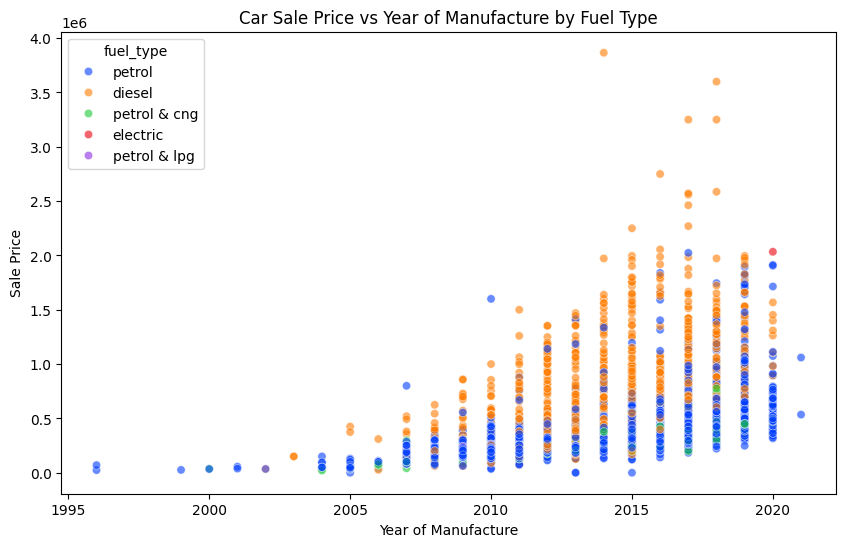

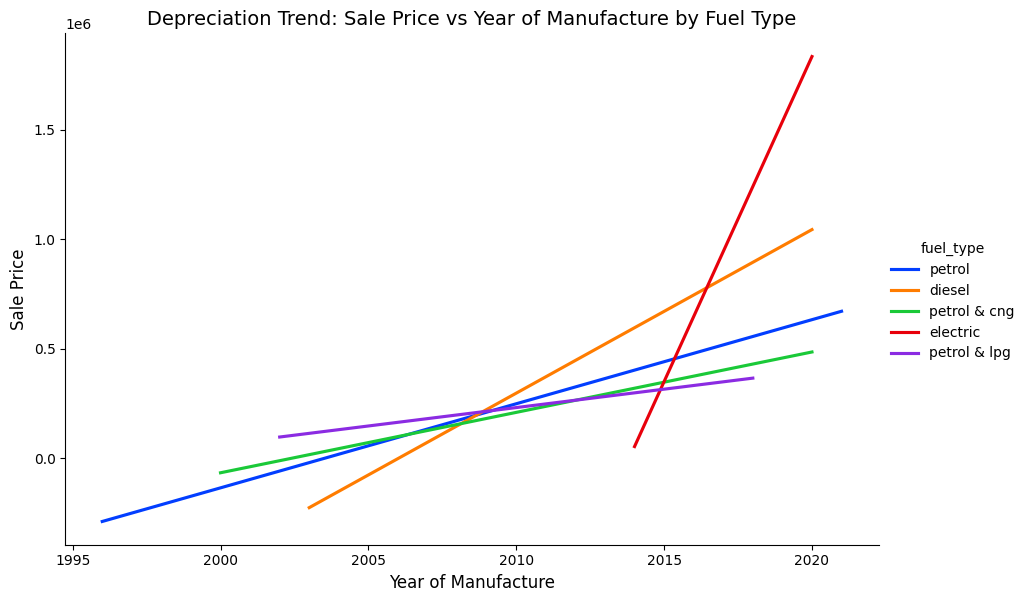

In [5]:
# Scatter layer: each point is a car, colored by fuel type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cars, x='yr_mfr', y='sale_price',
    hue='fuel_type', alpha=0.6, palette='bright')

# Scatter Plot Titles and labels
plt.title('Car Sale Price vs Year of Manufacture by Fuel Type')
plt.xlabel('Year of Manufacture')
plt.ylabel('Sale Price')

# Add trendlines (regression lines) per fuel type
sns.lmplot(data=cars, x='yr_mfr', y='sale_price',
    hue='fuel_type', scatter=False, aspect=1.5, height=6,
    ci=None, palette='bright')

# Trendlines Titles and labels
plt.title('Depreciation Trend: Sale Price vs Year of Manufacture by Fuel Type', fontsize=14)
plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.show()

**Sale price versus Km run densitity**  
Hexbin plot with log : understand how mileage affects price,
shows both correlation and density


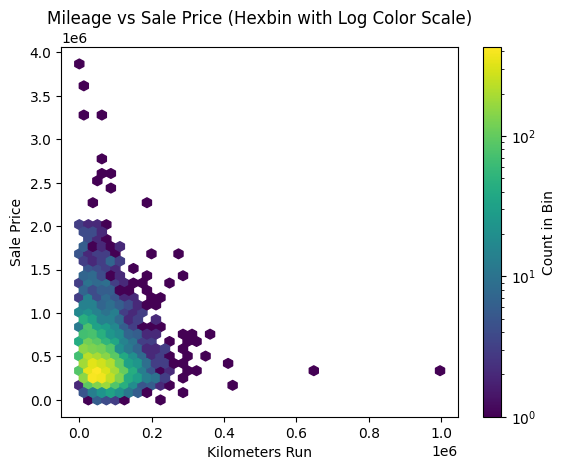

In [6]:
plt.hexbin(cars['kms_run'], cars['sale_price'],
            gridsize=40, cmap='viridis', norm=LogNorm())
plt.xlabel('Kilometers Run')
plt.ylabel('Sale Price')
plt.title('Mileage vs Sale Price (Hexbin with Log Color Scale)')
plt.colorbar(label='Count in Bin')
plt.show()

**Count of ads over time (monthly)**

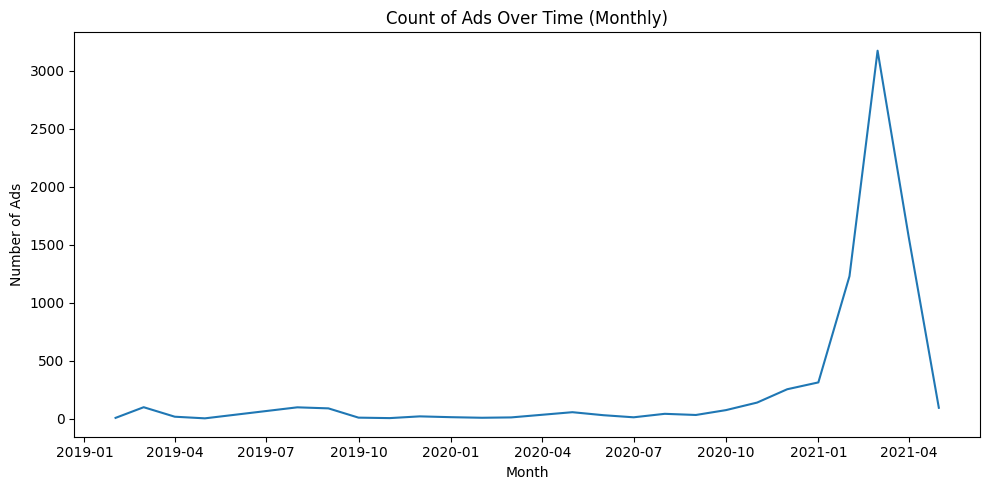

In [7]:

# Parse dates
df_time = cars[['ad_created_on']].copy()
df_time['ad_created_on'] = pd.to_datetime(df_time['ad_created_on'], errors='coerce')
df_time = df_time.dropna(subset=['ad_created_on'])

# Monthly counts
df_time['month'] = df_time['ad_created_on'].dt.to_period('M').dt.to_timestamp()
count_over_time = df_time.groupby('month').size().rename('num_ads')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(count_over_time.index, count_over_time.values)
plt.xlabel("Month")
plt.ylabel("Number of Ads")
plt.title("Count of Ads Over Time (Monthly)")
plt.tight_layout()
plt.show()

**Average sale price over time (monthly)**

In [8]:
cars['ad_created_on'] = pd.to_datetime(cars['ad_created_on'], errors='coerce')
cars['sale_price'] = pd.to_numeric(
    cars['sale_price'].astype(str).str.replace(r"[^\d.]", "", regex=True),
    errors='coerce'
)

# Drop missing values
df_time = cars.dropna(subset=['ad_created_on', 'sale_price']).copy()

# Extract month (as first day of that month for plotting)
df_time['month'] = df_time['ad_created_on'].dt.to_period('M').dt.to_timestamp()

# Group by month and take mean (average sale price per month)
avg_price_over_time = (
    df_time.groupby('month')['sale_price']
    .mean()
    .rename('avg_sale_price')
)

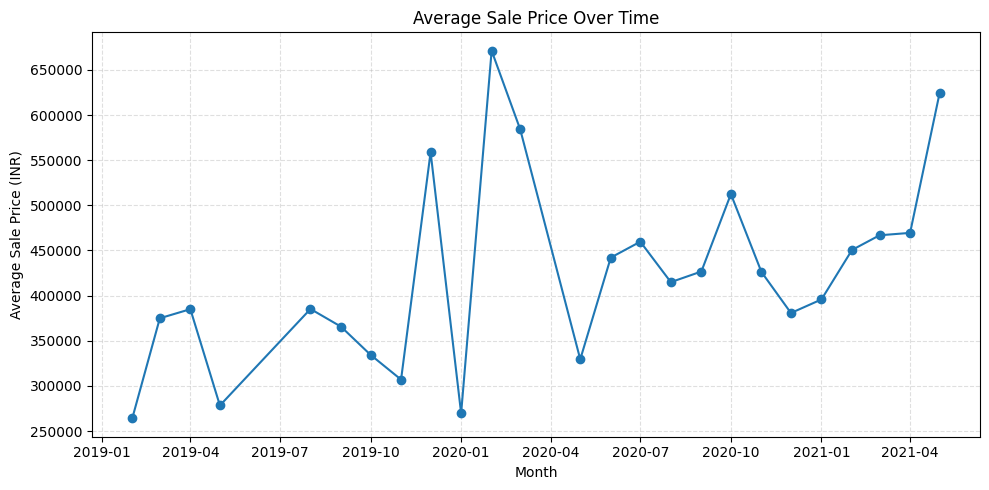

In [9]:
plt.figure(figsize=(10,5))
plt.plot(avg_price_over_time.index, avg_price_over_time.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Sale Price (INR)')
plt.title('Average Sale Price Over Time')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [10]:
# Suha's To Do:  Plot times viewed vs sale price.

In [11]:
#Suha's To Do: Study which fuel type attracts people more by plotting average times viewed versus fuel type.


In [12]:
# Suha's To Do: Study if the number of owners affects selling the car for less than the broker’s quote.


In [13]:
#Suha's To Do:  Plot the times viewed versus brand name to check which brands attract more buyers.

## Map Plots

In [14]:
# Geocode city names
geolocator = Nominatim(user_agent="city_mapper")
def geocode_city(city, country="India"):
  location = geolocator.geocode(f"{city}, {country}")
  if location:
    return location.latitude, location.longitude
  else:
    return None, None

cities = pd.DataFrame(cars["city"].astype('str').str.title().unique(), columns=["city"])
for city in cities["city"]:
    cities["lat"], cities["lon"] = geocode_city(city)  # your retry-safe function
    time.sleep(1)  # mandatory delay

In [15]:
# Create GeoData Frame
cars["city"] = cars["city"].astype("str").str.title()
df = pd.merge(cars, cities, how="outer", on="city")
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
map_cars = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [ ]:
# Load basic map of India
#world = gpd.read_file(get_path("naturalearth_lowres"))
#print(world.head())
#TODO: Find map of the world that can be imported with python
print(geodatasets.data)

{'geoda': {'airbnb': {'url': 'https://geodacenter.github.io/data-and-lab//data/airbnb.zip', 'license': 'NA', 'attribution': 'Center for Spatial Data Science, University of Chicago', 'name': 'geoda.airbnb', 'description': 'Airbnb rentals, socioeconomics, and crime in Chicago', 'geometry_type': 'Polygon', 'nrows': 77, 'ncols': 21, 'details': 'https://geodacenter.github.io/data-and-lab//airbnb/', 'hash': 'a2ab1e3f938226d287dd76cde18c00e2d3a260640dd826da7131827d9e76c824', 'filename': 'airbnb.zip'}, 'atlanta': {'url': 'https://geodacenter.github.io/data-and-lab//data/atlanta_hom.zip', 'license': 'NA', 'attribution': 'Center for Spatial Data Science, University of Chicago', 'name': 'geoda.atlanta', 'description': 'Atlanta, GA region homicide counts and rates', 'geometry_type': 'Polygon', 'nrows': 90, 'ncols': 24, 'details': 'https://geodacenter.github.io/data-and-lab//atlanta_old/', 'hash': 'a33a76e12168fe84361e60c88a9df4856730487305846c559715c89b1a2b5e09', 'filename': 'atlanta_hom.zip', 'me

In [ ]:
#TODO: City vs. brand name

In [ ]:
#TODO: City vs. average kilometers run

In [ ]:
#TODO: City vs. sale price for each car type

In [ ]:
#TODO: City vs transmission and fuel type